In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

You can check a burst's GBM detectors by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

--- 

- FullCatalog.fits holds ALL GRB sources contained in the 2nd Fermi-LAT GRB Catalog
- RS=null.fits holds GRBs which have a null in the redshift parameter
---
\tableofcontents

In [18]:
### Helper functions -- always run this cell

def clean_data(targets):
    # Cleans columns & GRB names
    
    # Remove trailing whitespace
    targets = targets.rename(columns=lambda x: x.strip().lower())
    # Cleans GRB names
    targets['name'] = targets['name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)[1:]
    return targets

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

def calculate_hardness(targets):
    # Calculates flux, flux_ene & fluence ratios with corresponding error
    targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
    targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
    targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']
    targets['hardness'] = targets['like_lat_fluence']/targets['like_gbm_fluence']



    targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                                  targets['like_lat_flux'],
                                                  targets['like_gbm_flux_error'],
                                                  targets['like_lat_flux_error'])

    targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                      targets['like_lat_flux_ene'],
                                                      targets['like_gbm_flux_ene_error'],
                                                      targets['like_lat_flux_ene_error'])

    targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                      targets['like_lat_fluence'],
                                                      targets['like_gbm_fluence_error'],
                                                      targets['like_lat_fluence_error'])
    
    targets['hardness_error'] = propagate_error(targets['like_lat_fluence'],
                                                targets['like_gbm_fluence'],
                                                targets['like_lat_fluence_error'],
                                                targets['like_gbm_fluence_error'])
    return targets

def calculate_time_difference(targets):
    # Calculate like & gbm-lle time differences
    targets['like_gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']
    targets['gbm-lle_time_difference'] = targets['gbm_cat_t05'] - targets['lle_t90']
    return targets

# Starting with just RS=null datset

Let's start with the RS=null dataset & take a look at hardness vs. burst duration and angular density.

In [19]:
# Load the RS=null.fits dataset
dat = Table.read('RS=null.fits')
all_candidates = dat.to_pandas()

# Cleaning data
all_candidates = clean_data(all_candidates)
all_candidates = calculate_hardness(all_candidates)
all_candidates = calculate_time_difference(all_candidates)

all_candidates.info()

all_candidates.T.tail(8).T.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 117 entries, name to gbm-lle_time_difference
dtypes: float64(111), int16(2), object(4)
memory usage: 168.0+ KB


,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_time_difference
count,179.0,179.0,128.0,128.0,128.0,128.0,186.0,186.0
unique,130.0,130.0,115.0,115.0,115.0,115.0,178.0,142.0
top,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0
freq,43.0,43.0,14.0,14.0,14.0,14.0,7.0,11.0


The original method simply extracted all sources with a gbm-lat_time_difference > 0.

In [20]:
original_targets = all_candidates[ all_candidates['like_gbm-lat_time_difference'] > 0 ]

original_targets[['like_gbm-lat_time_difference', 'gbm-lle_time_difference', 
                  'lle_t90', 'fluence_ratio', 'flux_ratio',
         'flux_ene_ratio', 'hardness', 'tl100', 'Like_LAT_GRBIndex'.lower(), 'gbm_cat_t90']].corr()

,like_gbm-lat_time_difference,gbm-lle_time_difference,lle_t90,fluence_ratio,flux_ratio,flux_ene_ratio,hardness,tl100,like_lat_grbindex,gbm_cat_t90
like_gbm-lat_time_difference,1.000000,0.883330,0.652774,-0.360266,-0.085024,-0.083995,0.636730,0.226738,-0.207656,0.177010
gbm-lle_time_difference,0.883330,1.000000,0.368750,-0.113933,-0.331636,-0.260577,0.499223,-0.126596,-0.282277,-0.111074
lle_t90,0.652774,0.368750,1.000000,-0.678517,0.388889,0.313331,0.669660,0.549679,-0.092251,0.284909
fluence_ratio,-0.360266,-0.113933,-0.678517,1.000000,-0.571144,-0.488411,-0.763150,-0.353920,-0.648098,0.254352
flux_ratio,-0.085024,-0.331636,0.388889,-0.571144,1.000000,0.973617,0.200153,0.598289,0.585887,0.170301
flux_ene_ratio,-0.083995,-0.260577,0.313331,-0.488411,0.973617,1.000000,0.080789,0.453961,0.454122,0.054392
hardness,0.636730,0.499223,0.669660,-0.763150,0.200153,0.080789,1.000000,0.467463,-0.424088,0.163211
tl100,0.226738,-0.126596,0.549679,-0.353920,0.598289,0.453961,0.467463,1.000000,-0.166795,0.786650
like_lat_grbindex,-0.207656,-0.282277,-0.092251,-0.648098,0.585887,0.454122,-0.424088,-0.166795,1.000000,-0.247354
gbm_cat_t90,0.177010,-0.111074,0.284909,0.254352,0.170301,0.054392,0.163211,0.786650,-0.247354,1.000000


There should be a negative correlation between burst duration and corresponding fluence ratio (0927-6505(96)00018-7, Figure 2.)

(-0.75, 8.0)

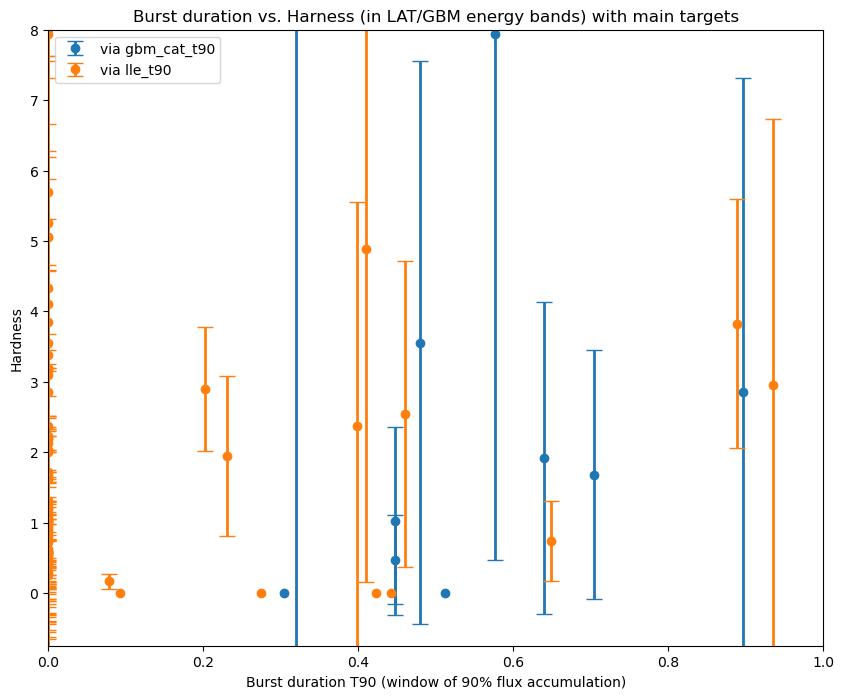

In [21]:
fig, ax = plt.subplots()
ax.errorbar(x = all_candidates['gbm_cat_t90'], y=all_candidates['hardness'], 
            yerr = all_candidates['hardness_error'], fmt = 'o', linewidth = 2, capsize = 6, 
            label = 'via gbm_cat_t90')
ax.errorbar(x = all_candidates['lle_t90'], y=all_candidates['hardness'], 
            yerr = all_candidates['hardness_error'], fmt = 'o', linewidth = 2, capsize = 6, 
            label = 'via lle_t90')

ax.legend()
ax.set_xlabel('Burst duration T90 (window of 90% flux accumulation)')
ax.set_ylabel('Hardness')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Harness (in LAT/GBM energy bands) with main targets')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,1)
ax.set_ylim(-.75,8)

Try to see if the considered correlation does exist by seeing if there's that negative correlation.

In [22]:
targets = all_candidates.copy()

# Polyfit does not like NaNs or infs
print('Dropping %s targets for inf hardness'% len(targets.loc[targets['hardness'] == np.inf]) )
targets = targets.loc[ targets['hardness'] != np.inf ]
print('Dropping %s targets for NaN hardness'% len(targets.loc[ np.isnan(targets['hardness']) ]) )
targets = targets.loc[ ~np.isnan(targets['hardness']) ]

# These ones will have had a 0.0 in the LAT flux, causing a NaN
print('Dropping %s targets for NaN hardness_error'% len(targets.loc[ np.isnan(targets['hardness_error']) ]) )
targets = targets.loc[ ~np.isnan(targets['hardness_error']) ]

# These ones will have had a 0.0 in GBM flux, causing a 0.
print('Dropping %s targets for 0. hardness_error'%len(targets[targets['hardness_error'] ==0]))
targets = targets[targets['hardness_error'] !=0]

Dropping 43 targets for inf hardness
Dropping 7 targets for NaN hardness
Dropping 8 targets for NaN hardness_error
Dropping 14 targets for 0. hardness_error


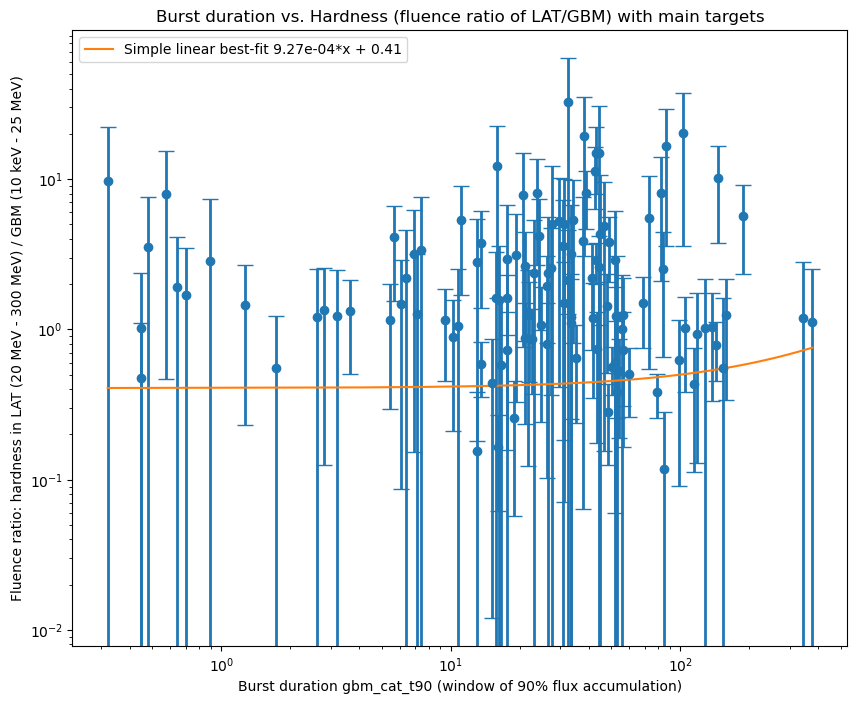

In [23]:
# Fit data with a simple linear correlation
result = np.polyfit(x = targets['gbm_cat_t90'], y = targets['hardness'], 
                 deg = 1, w = 1/targets['hardness_error'], full=True)
fit = result[0]

fig, ax = plt.subplots()
ax.errorbar(x = targets['gbm_cat_t90'], y=targets['hardness'], 
            yerr = targets['hardness_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration gbm_cat_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio: hardness in LAT (20 MeV - 300 MeV) / GBM (10 keV - 25 MeV)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Hardness (fluence ratio of LAT/GBM) with main targets')
#ax.set_xscale('log')

stats = targets['gbm_cat_t90'].describe()

time_domain = np.linspace(stats['min'], stats['max'], 100)

ax.plot(time_domain, time_domain*fit[0] + fit[1] 
        , '-', label = 'Simple linear best-fit %.2e*x + %.2f'%(fit[0], fit[1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

#plt.figtext(0.5, 0.01, 
#            'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)', 
#            horizontalalignment='center', fontsize=9)

In [8]:
fig.savefig('Burst_duration_vs_hardness.png')

Time to focus a little on their angular distribution. Since the candidates aren't parsed down, the distribution won't mean too much. I'm curious, though, whether Cline's anomalous overdense region shows up.

In [97]:

def generate_mollweise(targets, log_hardness = False, burst_duration_col='lle_t90', calculate_isotropy=True):

    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='mollweide')
    plt.grid(True)
    ax2 = fig.add_subplot(212, projection='mollweide')
    plt.grid(True)

    # change the >180s to negative
    modified = targets.copy()
    modified.loc[modified['lii']>180, 'lii'] -= (360)

    fig.set_figwidth(20)
    fig.set_figheight(11)
    
    if log_hardness is True:
        modified['hardness'] = np.log(modified['hardness'])
        ax1.set_title('log(Hardness): darker  = harder')
    else:
        ax1.set_title('Hardness: darker  = harder')
    ax1.scatter(modified['lii']*(np.pi/180), targets['bii']*(np.pi/180), 50, 
                c=modified['hardness'], cmap='Greens', edgecolors='lightgray')

    # quick parse-out of the 0 t90s
    nonzeros = targets[ targets[burst_duration_col]!=0.0 ]
    modified = modified[ targets[burst_duration_col]!=0.0 ]

    ax2.set_title('log(1/Burst Duration): darker = shorter')#, rotation=-90, position=(1, .5), ha='left', va='center')
    ax2.scatter(modified['lii']*(np.pi/180), modified['bii']*(np.pi/180), 50, 
                c=np.log10(1/nonzeros[burst_duration_col]), cmap='Greens', edgecolors='lightgray')

    ax1.set_ylabel('Gal. Longitude')
    ax2.set_xlabel('Gal. Latitude')

    caption = 'In Gal. Lat/Long coords, the galactic center is at (0,0) and the plane is on the x-axis.'
    
    if calculate_isotropy:
        #### TODO
        center = modified.query('lii > -90 and lii < 90').shape[0]
        anticenter = modified.query('lii > 90 or lii < -90').shape[0]
        caption += '\ncenter/anticenter numerical ratio of %.2f'%(center/anticenter)
        northern = modified.query('bii > 0 and bii < 90').shape[0]
        southern = modified.query('bii < 0 and bii > -90').shape[0]
        caption += '\nnothern/southern num. ratio of %.2f'%(northern/southern)
    
    plt.figtext(0.5, 0.01, 
                caption, 
                horizontalalignment='center', fontsize=10)
    return fig

#fig = generate_mollweise(targets)

#fig.savefig('AngularDistribution.png')

---

# Now with the full dataset

Let's try to enforce the same restrictions that Cline did on their BATSE data.

- Hardness >0
- Burst Duration <1s

Also, we need to figure out a way to determine the actual burst duration in the way that Cline did.

In [74]:
# Load the FullCatalog.fits dataset
dat = Table.read('FullCatalog.fits')
all_candidates = dat.to_pandas()

# Cleaning data
all_candidates = clean_data(all_candidates)
all_candidates = calculate_hardness(all_candidates)
all_candidates = calculate_time_difference(all_candidates)

all_candidates.info()

all_candidates.T.tail(8).T.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Columns: 117 entries, name to gbm-lle_time_difference
dtypes: float64(111), int16(2), object(4)
memory usage: 208.6+ KB


,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_time_difference
count,223.0,223.0,157.0,157.0,157.0,157.0,231.0,231.0
unique,159.0,159.0,143.0,143.0,143.0,143.0,222.0,174.0
top,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0
freq,58.0,58.0,15.0,15.0,15.0,15.0,8.0,13.0


In [75]:
# Do we want the ones with the highest hardness value?
print('Sorted by hardness: ')
print(all_candidates[['hardness', 'name', 'ra', 'dec', 'lle_t90', 'gbm_cat_t90']].loc[all_candidates[
    'hardness'] != np.inf].sort_values(by='hardness', ascending=False).head(20))


# I want to get the smallest burst-duration one too
print('\nSorted by LLE burst duration:')
print(all_candidates[ all_candidates['lle_t90']!=0.0 ][[
    'lle_t90', 'name', 'ra', 'dec', 'hardness', 'gbm_cat_t90']].sort_values(
    by = 'lle_t90', ascending=True).head(20))

print('\nSorted by GBM burst duration:')
print(all_candidates[['gbm_cat_t90', 'name', 'ra', 'dec', 'hardness', 'lle_t90']].sort_values(
    by = 'gbm_cat_t90', ascending=True).head(20))

Sorted by hardness: 
      hardness          name       ra     dec  lle_t90  gbm_cat_t90
115  92.767876  GRB131231198   10.550  -1.720   12.796       31.232
34   32.573197  GRB220408311   92.480 -50.970    0.000       32.513
144  20.354248  GRB100116897  305.000  14.510    6.657      102.530
47   19.184728  GRB190531840   24.390 -41.950    6.702       38.145
98   16.462146  GRB130821674  314.230 -11.520    9.275       87.041
189  14.992157  GRB160821857  171.290  42.290   34.923       43.009
157  14.962628  GRB171120556  163.820  22.410    0.000       44.062
150  13.230824  GRB090323002  190.750  17.070   86.177      133.890
1    12.136621  GRB190731943  340.310 -76.420    6.354       15.872
117  11.353343  GRB100511035  111.380  -0.990    0.000       42.433
113  11.165293  GRB180720598    0.590  -2.950   30.555       48.897
103  10.138404  GRB140206275  315.240  -8.790   27.601      146.690
131   9.669260  GRB140402007  207.660   5.970    1.546        0.320
135   8.785904  GRB10041409

In [84]:
all_lt_2 = all_candidates.query('gbm_cat_t90<2 or lle_t90<2')#.to_csv('<2s_t90_dataset.csv')

             gbm_cat_t90   lle_t90  hardness  redshift
gbm_cat_t90     1.000000 -0.044716 -0.068406  0.133772
lle_t90        -0.044716  1.000000 -0.038515  0.011062
hardness       -0.068406 -0.038515  1.000000  0.058853
redshift        0.133772  0.011062  0.058853  1.000000


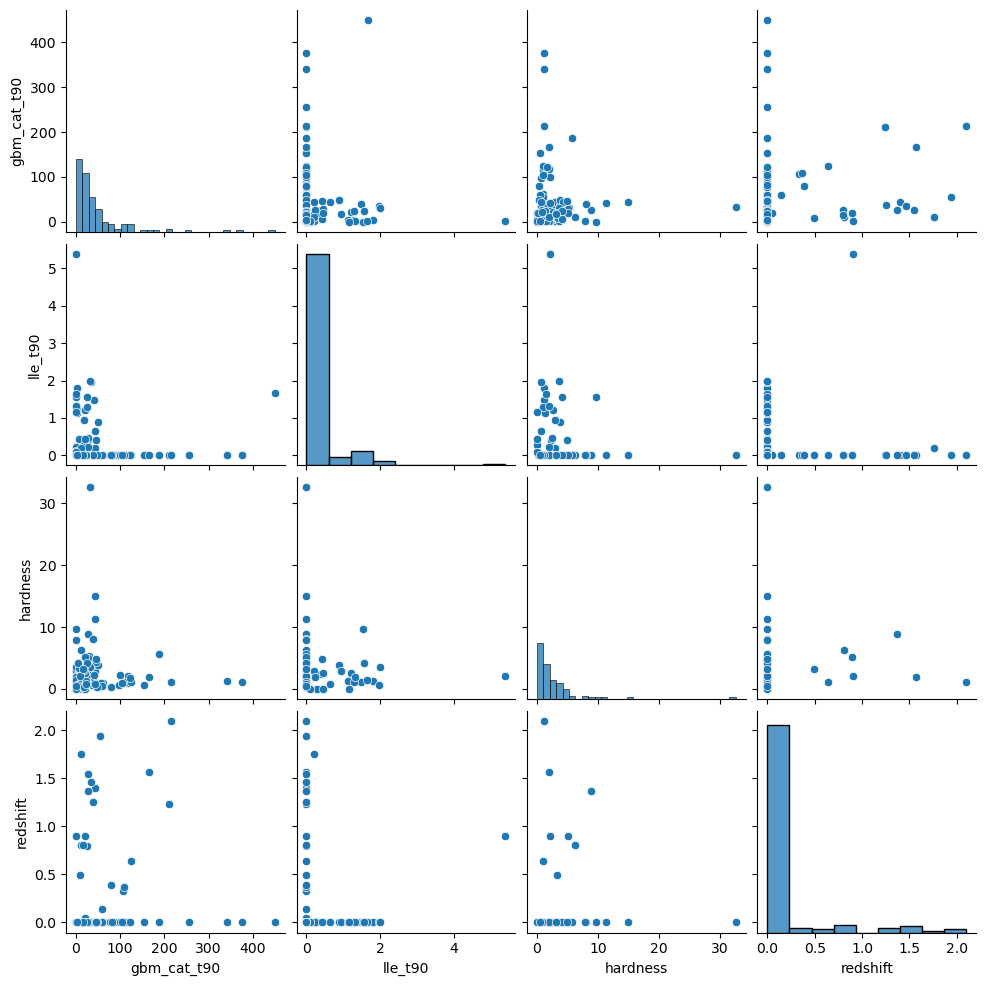

In [85]:
keep_cols = ['gbm_cat_t90','lle_t90','hardness', 'redshift']

print(all_lt_2[keep_cols].corr())
sns.pairplot(all_lt_2[keep_cols])

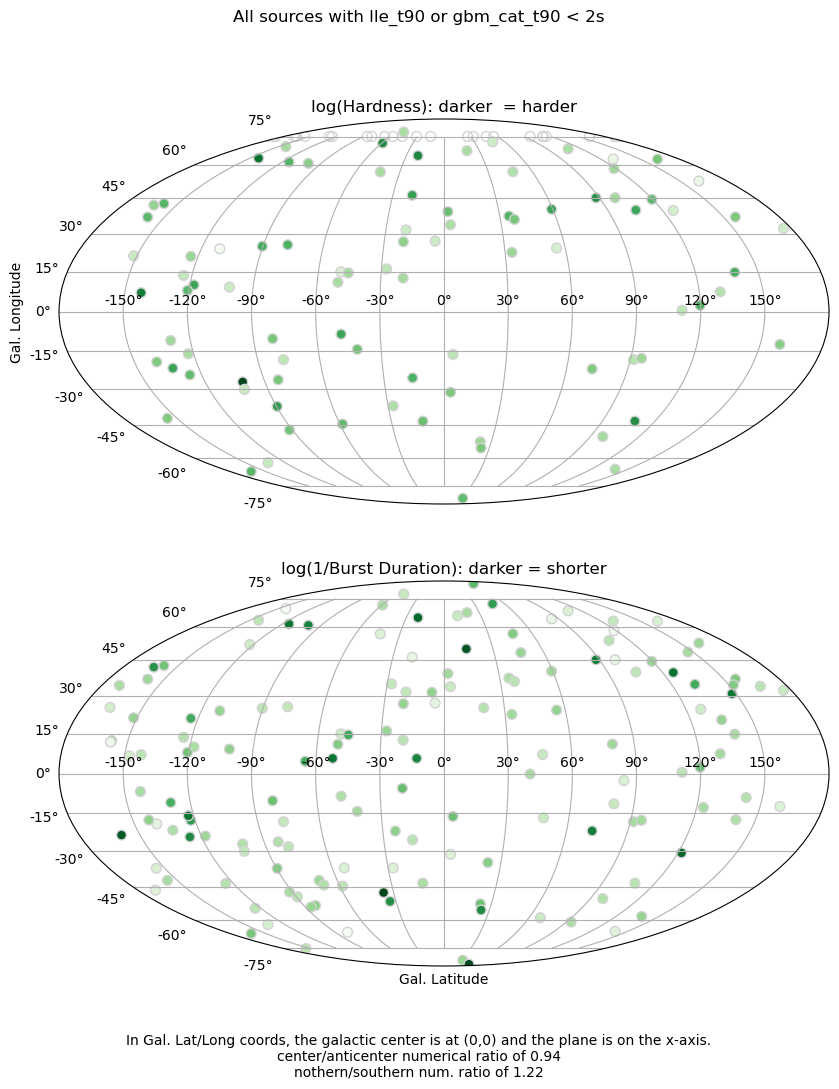

In [98]:
# Generally pretty isotropic, somehow also outside of the galactic plane

fig = generate_mollweise(all_lt_2, log_hardness=True, burst_duration_col='gbm_cat_t90', calculate_isotropy=True)
fig.suptitle('All sources with lle_t90 or gbm_cat_t90 < 2s')
fig.savefig('t90<2sAngularDistribution.png')

---
---
---

In [47]:
# The ones with decent signal
cols = ['name', 'ra', 'dec', 'lle_t90', 'gbm_cat_t90', 'hardness', 'like_gbm_ts']

all_candidates.query('name in ["GRB141222298", "GRB090227772", "GRB110529034", "GRB131014215"]')

,name,gcn_name,time,trigger_met,ra,dec,lii,bii,error_radius,redshift,...,flux_ratio,flux_ene_ratio,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_time_difference
20,GRB141222298,b'GRB141222A ',57013.297882,4.409249e+08,178.00,-57.31,294.9442,4.6371,0.08,0.0,...,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,-34.210,-1.293
73,GRB131014215,b'GRB131014A ',56579.214583,4.034201e+08,100.78,-20.76,230.7301,-11.0592,0.81,0.0,...,63.250398,50.702326,0.816955,1.224058,35.996179,53.493315,0.861926,1.264234,-0.890,-0.851
145,GRB090227772,b'GRB090227B ',54889.771539,2.574523e+08,11.80,32.20,121.8897,-30.6632,1.80,0.0,...,inf,inf,inf,0.000000,NaN,NaN,NaN,NaN,-0.016,-1.160
177,GRB110529034,b'GRB110529A ',55710.033819,3.283229e+08,118.33,67.91,147.8849,30.7830,1.50,0.0,...,inf,inf,inf,0.000000,NaN,NaN,NaN,NaN,-0.128,-0.221


In [133]:
#Sources that Connor likes

keep_cols = ['name', 'lle_t90', 'gbm_cat_t90', 'hardness', 'like_gbm_ts', 'lii', 'bii'] #'ra', 'dec'

#top = [ "GRB190606080" , "GRB141222298" , "GRB131014215" , "GRB090227772" ]
#tot = [ "GRB150314205" , "GRB131216081" , "GRB110120666" , "GRB090510016" ,
#       "GRB110921912" ] + top + ["GRB110529034"]

selection = ["GRB170127067","GRB141102536","GRB200415367","GRB200219998","GRB210306162","GRB160521385","GRB200219317",
           "GRB210202841","GRB131014215","GRB081009140","GRB110428388","GRB141222298","GRB180703949","GRB130325203",
           "GRB170522657","GRB110529034","GRB090720710","GRB120830297","GRB130310840","GRB200716957","GRB170728961",
           "GRB100620119","GRB090228204","GRB190606080","GRB090227772","GRB081224887","GRB160422499","GRB110921912",
           "GRB110120666","GRB170228794","GRB080825593","GRB181120265","GRB210802839"]
#top = all_candidates.query( 'name in @top' )#[keep_cols]
#tot = all_candidates.query( 'name in @tot' )#[keep_cols]
selection = all_candidates.query( 'name in @selection' )

print(selection[keep_cols].corr())


              lle_t90  gbm_cat_t90  hardness  like_gbm_ts       lii       bii
lle_t90      1.000000    -0.090731 -0.019263     0.591505 -0.091364 -0.132292
gbm_cat_t90 -0.090731     1.000000  0.101228     0.011539 -0.379257  0.189471
hardness    -0.019263     0.101228  1.000000     0.037745 -0.247104  0.073005
like_gbm_ts  0.591505     0.011539  0.037745     1.000000  0.004355  0.012600
lii         -0.091364    -0.379257 -0.247104     0.004355  1.000000 -0.289301
bii         -0.132292     0.189471  0.073005     0.012600 -0.289301  1.000000


In [134]:
sns.pairplot(selection)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe204029ef0> (for post_execute):


KeyboardInterrupt: 

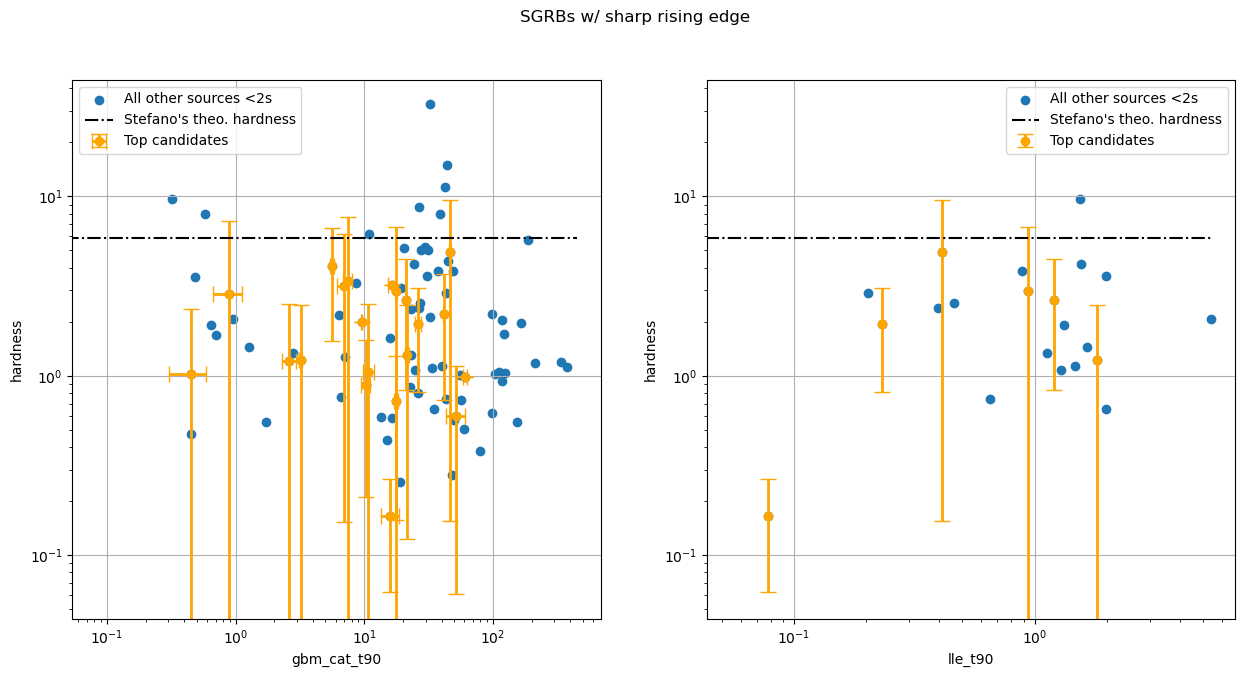

In [144]:
fig, ax_tuple = plt.subplots(1,2)

#####
ax = ax_tuple[0]

ax.errorbar(x = selection['gbm_cat_t90'], y = selection['hardness'], 
            xerr = selection['gbm_cat_t90_error'], yerr = selection['hardness_error'],
            fmt = 'o', linewidth = 2, capsize = 6,
            label = 'Top candidates', color = 'orange')



#####

ax = ax_tuple[1]

ax.errorbar(x = selection['lle_t90'], y = selection['hardness'], 
            yerr = selection['hardness_error'],
            fmt = 'o', linewidth = 2, capsize = 6,
            label = 'Top candidates', color = 'orange')

#####

param = 'gbm_cat_t90'
for ax in ax_tuple:

    all_except = all_lt_2.query('name not in @selection')
    ax.scatter(all_except[param], all_except['hardness'], label='All other sources <2s')
    
    ax.plot(np.linspace(0,all_lt_2[param].max(),100), np.ones(100)*5.9 , '-.', color = 'black',
       label = 'Stefano\'s theo. hardness')
    
    ax.grid()
    ax.legend()

    ax.set_xlabel(param)
    ax.set_ylabel('hardness')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    param = 'lle_t90'

fig.set_figwidth(15)
fig.set_figheight(7)

fig.suptitle('SGRBs w/ sharp rising edge')

plt.show()

fig.savefig('SharpSGRBs.png', dpi=200)